# Линейные модели. Домашняя работа. №3
# Функции потерь и оптимизации. Домашняя работа №5. 

## Задание к дз №3. (Часть 1)

* Имеются данные adult.csv (см. в материалах к занятию)

* Целевой переменной является уровень дохода income (крайний правый столбец).

Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

**Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.**

## Задание к дз №5. (Часть 2)

* Дана статистика пользователей adult.csv.
* **Получите значения AUC для различных моделей и их параметров.**
* Попробуйте построить модель с улучшенным значением AUC, чем в примерах на занятии.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'svg'
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%pylab inline

import warnings
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


# Часть 1.

In [2]:
allData = pd.read_csv('adult.csv')

In [3]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


**Пропущенных значений нет. Посмотрим на сами данные.**

In [4]:
allData.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
indexs = list(allData.index)

In [6]:
allData.income.value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

**Таким образом, перед нами стоит задача бинарной классификации. Пусть доход до 50 тысяч будет 0, а доход после 50 тысяч обозначим за 1.**

In [7]:
y = (allData['income'] == '>50K').astype(int)
X = allData.drop(['income'], axis=1)

**У нас имеется достаточно большое кол-во категариальных переменных, обработаем их с помошью pd.get_dummies.**

In [8]:
X = pd.get_dummies(X, columns=['age','workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'educational-num'])
columns = X.columns

In [9]:
X.head()

,fnlwgt,capital-gain,capital-loss,hours-per-week,age_17,age_18,age_19,age_20,age_21,age_22,...,educational-num_7,educational-num_8,educational-num_9,educational-num_10,educational-num_11,educational-num_12,educational-num_13,educational-num_14,educational-num_15,educational-num_16
0,226802,0,0,40,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,89814,0,0,50,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,336951,0,0,40,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,160323,7688,0,40,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,103497,0,0,30,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


**Отнормируем данные.**

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

**Подберем некоторые наиболее подходящие параметры для наших данных.**

In [12]:
%%time
 parameters = {
     'C':[0.01, 0.1, 1, 10, 100],
     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'max_iter':[10, 100, 200]
 }

gsearch = GridSearchCV(estimator=clf, param_grid = parameters, scoring='roc_auc', n_jobs=-1, iid=False, cv=5)
gsearch.fit(X_scaled,y)

Wall time: 13min 52s


In [13]:
gsearch.best_params_

{'C': 0.1, 'max_iter': 10, 'solver': 'liblinear'}

In [14]:
C_best = gsearch.best_params_['C']
max_iter_best = gsearch.best_params_['max_iter']
solver_best = gsearch.best_params_['solver']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

**Обучим модель.**

In [16]:
clf = LogisticRegression(
            C=C_best,
            solver=solver_best,
            max_iter=max_iter_best
                
)

clf.fit(X_train, y_train)

y_train_predict = clf.predict_proba(X_train)[:, 1]
y_test_predict = clf.predict_proba(X_test)[:, 1]

In [17]:
roc_auc_test = roc_auc_score(y_test, y_test_predict)
roc_auc_train = roc_auc_score(y_train, y_train_predict)

print('Train: ', roc_auc_train)
print('Test: ', roc_auc_test)

Train:  0.911547636349964
Test:  0.916931695431322


In [18]:
scores = cross_validate(
    clf, X_scaled, y, cv=3, scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall'), return_train_score=True
)
scores

{'fit_time': array([2.66782689, 2.33264732, 2.8722229 ]),
 'score_time': array([0.0312438 , 0.04686499, 0.05001903]),
 'test_accuracy': array([0.8543087 , 0.85301886, 0.85853808]),
 'test_f1': array([0.66591549, 0.6649867 , 0.67758645]),
 'test_precision': array([0.73782772, 0.73144441, 0.74507389]),
 'test_recall': array([0.60677618, 0.60959959, 0.62130937]),
 'test_roc_auc': array([0.90811394, 0.90721355, 0.91403826]),
 'train_accuracy': array([0.85771322, 0.85912595, 0.85679627]),
 'train_f1': array([0.67476307, 0.67902876, 0.67215074]),
 'train_precision': array([0.74465448, 0.74646154, 0.74327476]),
 'train_recall': array([0.61686561, 0.62276986, 0.61344969]),
 'train_roc_auc': array([0.91408708, 0.91516882, 0.9113309 ])}

In [19]:
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.7791460058531466

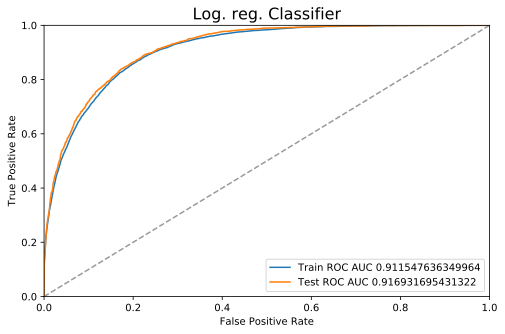

In [20]:
plt.figure(figsize=(8,5))
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log. reg. Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

**Посмотрим на распределение наших предсказаний более детально и сравним с реальными данными.**

In [21]:
y_test_pr = y_predict

trues = list(y_test == y_test_pr)

i = 0
y_test_pr_True = [] 
y_test_pr_False = []
for value in trues:
    if value == True:
        y_test_pr_True.append(y_test_pr[i])
    elif value == False:
        y_test_pr_False.append(y_test_pr[i])
    i += 1

trace0 = go.Histogram(x=y_test, xbins=dict(start=0, end=1, size=0.3), name='real' )
trace1 = go.Histogram(x=y_test_pr_True, xbins=dict(start=0, end=1, size=0.3), name='predict True')
trace2 = go.Histogram(x=y_test_pr_False, xbins=dict(start=0, end=1, size=0.3), name='predict False')

traces = [trace0, trace1, trace2]
layout = go.Layout(bargap=0.2,bargroupgap=0.1)
fig = go.Figure(data=traces, layout=layout)
iplot(fig, show_link=False)

**Колонка "predict False" отвечает за предсказания вида: мы предсказали класс 0 или 1 и ошиблись. Колонка "predict True" отвечает за предсказания вида: мы предсказали класс 0 или 1 и были правы.**

In [22]:
recall_score(y_test, y_predict), precision_score(y_test, y_predict), accuracy_score(y_test, y_predict)

(0.6219931271477663, 0.7533818938605619, 0.8613983007472618)

**Видно, что у нас достаточно низкий показатель полносты, но высокий показатель точности. Для некоторых задач полнота может быть важнее точности, поэтому можем увеличить полноту, за счет того, что будем присваевать класс 1 тем людям, у которых вероятность принадлежать классу 1 будет больше не 50%, а 25%.**

In [23]:
y_predict = (y_test_predict > 0.25).astype(int)

In [24]:
recall_score(y_test, y_predict), precision_score(y_test, y_predict), accuracy_score(y_test, y_predict)

(0.8505154639175257, 0.5873628003559774, 0.8219879209745112)

In [25]:
roc_auc_score(y_test, y_predict)

0.8317891121495975

**Видно, что полнота заметно выросла, точность (precision) упала, но при этом roc_auc_score вырос (был 0.7791460058531466)**

**Посмотрим распределение.**

In [26]:
y_test_pr = y_predict

trues = list(y_test == y_test_pr)

i = 0
y_test_pr_True = [] 
y_test_pr_False = []
for value in trues:
    if value == True:
        y_test_pr_True.append(y_test_pr[i])
    elif value == False:
        y_test_pr_False.append(y_test_pr[i])
    i += 1

trace0 = go.Histogram(x=y_test, xbins=dict(start=0, end=1, size=0.3), name='real' )
trace1 = go.Histogram(x=y_test_pr_True, xbins=dict(start=0, end=1, size=0.3), name='predict True')
trace2 = go.Histogram(x=y_test_pr_False, xbins=dict(start=0, end=1, size=0.3), name='predict False')

traces = [trace0, trace1, trace2]
layout = go.Layout(bargap=0.2,bargroupgap=0.1)
fig = go.Figure(data=traces, layout=layout)
iplot(fig, show_link=False)

**Посмотрим на самые важные фичи.**

In [27]:
fe_imp = {}
coefs = clf.coef_[0]
for i in range(0, len(columns)):
    name = columns[i]
    fe_imp[name] = coefs[i]

In [28]:
fe_imp_sorted = sorted(fe_imp.items(), key=lambda x: abs(x[1]))[::-1]

In [29]:
values = [i[1] for i in fe_imp_sorted]
names = [i[0] for i in fe_imp_sorted]

In [30]:
trace = go.Bar(x=names[:10], y=values[:10])

data = [trace]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

**Мы специально выводим не только сам модуль значения фичи, но и ее знак, чтобы можно было понимать какого вида вклад она вносит. Так, можно, например, заметить, что никогда не выходившие замуж иметь меньше вероятности иметь зарплату >50K.**

# Часть №2

### Теперь обучим различные модели и посмотрим на их качество.

In [31]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier

**Выберем 5 моделей.**

In [32]:
models = [
    GradientBoostingClassifier(), 
    RandomForestClassifier(), 
    DecisionTreeClassifier(), 
    ExtraTreeClassifier(),
    XGBClassifier()
]

**С помощью GridSearchCV найдем для различных параметров оптимальные конфигурации.**

In [33]:
%%time
 parameters = {
     'max_depth':range(5, 9, 1),
     'min_samples_split':np.arange(0.1, 0.7, 0.1),
     'min_samples_leaf':np.arange(0.1, 0.6, 0.1) 
 }

best_params = []
for model in models:
    if str(model).split('(')[0] == 'XGBClassifier':
        parameters['learning_rate'] = np.arange(0.1, 0.7, 0.1)
        del parameters['min_samples_split']
        del parameters['min_samples_leaf']

    gsearch = GridSearchCV(estimator=model, param_grid = parameters, scoring='roc_auc', n_jobs=-1, iid=False, cv=3)
    gsearch.fit(X_scaled,y)
    print('{}: best params = {}\n'.format(str(model).split('(')[0], gsearch.best_params_))
    best_params.append(gsearch.best_params_)

GradientBoostingClassifier: best params = {'max_depth': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

RandomForestClassifier: best params = {'max_depth': 7, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4}

DecisionTreeClassifier: best params = {'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

ExtraTreeClassifier: best params = {'max_depth': 7, 'min_samples_leaf': 0.30000000000000004, 'min_samples_split': 0.4}

XGBClassifier: best params = {'learning_rate': 0.2, 'max_depth': 7}

Wall time: 27min 35s


In [34]:
models = [
    GradientBoostingClassifier(
        max_depth=best_params[0]['max_depth'],
        min_samples_split=best_params[0]['min_samples_split']
    ), 
    RandomForestClassifier(
        max_depth=best_params[1]['max_depth'],
        min_samples_split=best_params[1]['min_samples_split']
    ), 
    DecisionTreeClassifier(
        max_depth=best_params[2]['max_depth'],
        min_samples_split=best_params[2]['min_samples_split']
    ), 
    ExtraTreeClassifier(
        max_depth=best_params[3]['max_depth'],
        min_samples_split=best_params[3]['min_samples_split']
    ), 
    XGBClassifier(
        max_depth=best_params[4]['max_depth'],
        learning_rate=best_params[4]['learning_rate']
    )
]

**Обучим модели на оптимальных параметрах и выведем различные метрики качества для наших обученных моделей.**

In [35]:
for model in models:
    model.fit(X_train, y_train)
    y_test_predict = model.predict_proba(X_test)[:, 1]
    print('{}: качество (ROC_AUC) = {}'.format(str(model).split('(')[0], roc_auc_score(y_test, y_test_predict)))
    print('{}: качество (PRC_AUC) = {}'.format(str(model).split('(')[0], average_precision_score(y_test, y_test_predict)))
    print('{}: качество (recall) = {}'.format(str(model).split('(')[0], recall_score(y_test, y_test_predict.round())))
    print('{}: качество (precision) = {}'.format(str(model).split('(')[0], precision_score(y_test, y_test_predict.round())))
    print('{}: качество (accuracy) = {}\n'.format(str(model).split('(')[0], accuracy_score(y_test, y_test_predict.round())))


GradientBoostingClassifier: качество (ROC_AUC) = 0.9249968884664747
GradientBoostingClassifier: качество (PRC_AUC) = 0.8202457146788893
GradientBoostingClassifier: качество (recall) = 0.6172680412371134
GradientBoostingClassifier: качество (precision) = 0.7939226519337017
GradientBoostingClassifier: качество (accuracy) = 0.8706111167980346

RandomForestClassifier: качество (ROC_AUC) = 0.8757450073452973
RandomForestClassifier: качество (PRC_AUC) = 0.6840802934947442
RandomForestClassifier: качество (recall) = 0.10481099656357389
RandomForestClassifier: качество (precision) = 0.991869918699187
RandomForestClassifier: качество (accuracy) = 0.7864673968676426

DecisionTreeClassifier: качество (ROC_AUC) = 0.8710564631920016
DecisionTreeClassifier: качество (PRC_AUC) = 0.6703266370644425
DecisionTreeClassifier: качество (recall) = 0.5107388316151202
DecisionTreeClassifier: качество (precision) = 0.7515802781289507
DecisionTreeClassifier: качество (accuracy) = 0.8431773978912888

ExtraTreeCl

**Таким образом, наилучшей моделью для данной задачи оказалась XGBClassifier.**

**Визуализируем ROС-кривую для XGBClassifier.**

In [36]:
model = XGBClassifier(
        max_depth=best_params[4]['max_depth'],
        learning_rate=best_params[4]['learning_rate']
)

model.fit(X_train, y_train)
y_test_predict = model.predict_proba(X_test)[:, 1]
y_train_predict = model.predict_proba(X_train)[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_predict)
roc_auc_train = roc_auc_score(y_train, y_train_predict)

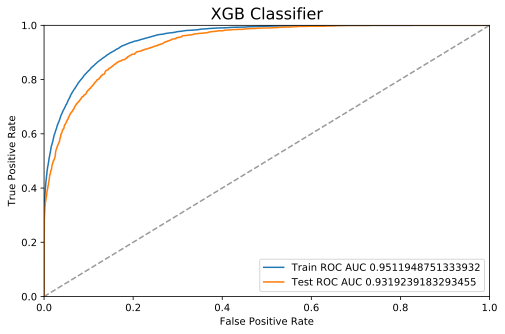

In [37]:
plt.figure(figsize=(8,5))
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

**Визуализируем PRC-кривую для XGBClassifier.**

In [39]:
from sklearn.metrics import precision_recall_curve

average_precision_score_test = average_precision_score(y_test, y_test_predict)
average_precision_score_train = average_precision_score(y_train, y_train_predict)

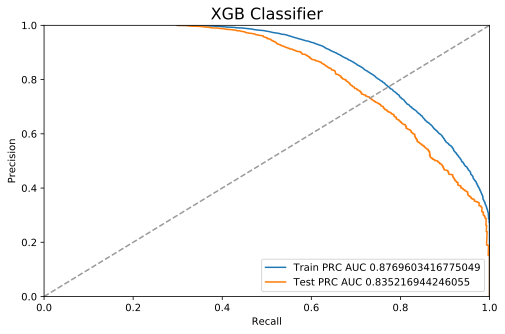

In [40]:
plt.figure(figsize=(8,5))
fpr_train, tpr_train, thresholds_train = precision_recall_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = precision_recall_curve(y_test, y_test_predict)

plt.plot(fpr_train, tpr_train, label='Train PRC AUC {0}'.format(average_precision_score_train))
plt.plot(fpr_test, tpr_test, label='Test PRC AUC {0}'.format(average_precision_score_test))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [41]:
model0 = XGBClassifier(
        max_depth=best_params[4]['max_depth'],
        learning_rate=best_params[4]['learning_rate']
)

model0.fit(X_train, y_train)
y_test_predict0 = model0.predict_proba(X_test)[:, 1]

roc_auc_test0 = roc_auc_score(y_test, y_test_predict0)

In [42]:
model1 = XGBClassifier()

model1.fit(X_train, y_train)
y_test_predict1 = model1.predict_proba(X_test)[:, 1]

roc_auc_test1 = roc_auc_score(y_test, y_test_predict1)

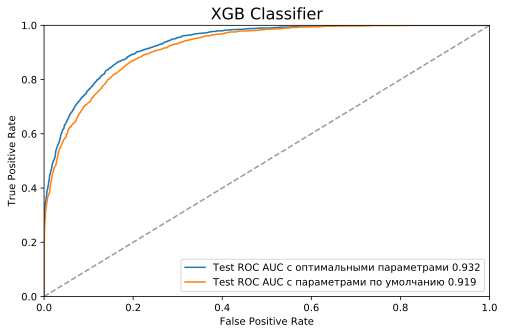

In [48]:
plt.figure(figsize=(8,5))
fpr_test0, tpr_test0, thresholds_test = roc_curve(y_test, y_test_predict0)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict1)

plt.plot(fpr_test0, tpr_test0, label='Test ROC AUC c оптимальными параметрами {:.3f}'.format(roc_auc_test0))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC с параметрами по умолчанию {:.3f}'.format(roc_auc_test1))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [46]:
average_precision_score_test0 = average_precision_score(y_test, y_test_predict0)
average_precision_score_test1 = average_precision_score(y_test, y_test_predict1)

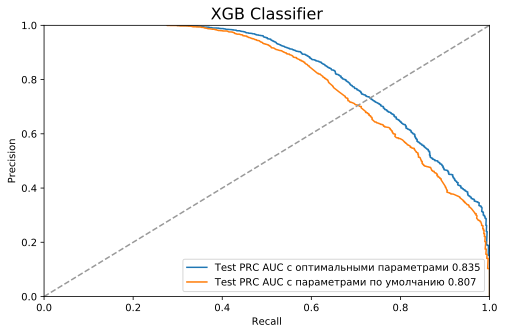

In [49]:
plt.figure(figsize=(8,5))
fpr_test0, tpr_test0, thresholds_test0 = precision_recall_curve(y_test, y_test_predict0)
fpr_test, tpr_test, thresholds_test = precision_recall_curve(y_test, y_test_predict1)

plt.plot(fpr_test0, tpr_test0, label='Test PRC AUC c оптимальными параметрами {:.3f}'.format(average_precision_score_test0))
plt.plot(fpr_test, tpr_test, label='Test PRC AUC с параметрами по умолчанию {:.3f}'.format(average_precision_score_test1))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

**Таким образом нам удалось увеличить точность модели с помощью подбора параметров.**